# Прогнозирование стоимости автомобиля по характеристикам

# Описание признаков в датасете train
- bodyType - тип кузова
- brand - марка автомобиля
- car_url - адрес страницы с объявлением
- color - цвет автомобиля
- complectation_dict - словарь с параметрами комплектации авто
- description - описание автомобиля
- engineDisplacement - объем двигателя
- enginePower - мощность двигателя
- equipment_dict - словарь оснащения авто
- fuelType - тип топлива
- image - изображение
- mileage - пробег
- modelDate - дата выпуска модели
- model_info - информация о модели
- model_name - название модели
- name - имя
- numberOfDoors - кол-во дверей
- parsing_unixtime - когда был произведен парсинг данных
- priceCurrency - валюта
- productionDate - год производства
- sell_id
- super_gen - словарь с дополинтельной информацией
- vehicleConfiguration - конфигурация транспортного средства
- vehicleTransmission - трансмиссия
- vendor - страна-изготовитель
- Владельцы - кол-во владельцев
- Владение - период владения
- ПТС
- Привод
- Руль
- Состояние
- Таможня

In [1]:
import requests
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/sf-dst-car-price-prediction/sample_submission.csv
/kaggle/input/sf-dst-car-price-prediction/test.csv
/kaggle/input/cars-df/cars_df.csv


In [2]:
import re
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
import datetime
import requests as r
import pandas_profiling
import xgboost as xgb

from pandas import Series
from tqdm import tqdm
from collections import Counter
from sklearn.base import clone

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import f_regression
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor


warnings.simplefilter('ignore')

In [3]:
#from bs4 import BeautifulSoup

In [4]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [5]:
#запишем функцию для вычисления итоговой метрики
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

# Код парсинга 

In [6]:
START_URL='https://auto.ru/moskva/cars/used/'

In [7]:
pages_url_list=[]

In [8]:
"""while len(pages_url_list)<5000: 
    for i in range(1,99):   
        response = r.get( START_URL+'?page=%s'%i)
        page = BeautifulSoup(response.text, 'html.parser')
        for link in page.findAll('a',{"class": "Link OfferThumb"}):
            try:
                if link['href'] not in pages_url_list: 
                    pages_url_list.append(link['href'])
            except:
                pass
    print(len(pages_url_list))   
    time.sleep(10)"""

'while len(pages_url_list)<5000: \n    for i in range(1,99):   \n        response = r.get( START_URL+\'?page=%s\'%i)\n        page = BeautifulSoup(response.text, \'html.parser\')\n        for link in page.findAll(\'a\',{"class": "Link OfferThumb"}):\n            try:\n                if link[\'href\'] not in pages_url_list: \n                    pages_url_list.append(link[\'href\'])\n            except:\n                pass\n    print(len(pages_url_list))   \n    time.sleep(10)'

Создаем датафрейм с учетом заранее проанализированных признаков, часть из них в test неинформативна, не будем тратить на них время. Используем библиотеку BeautifulSoup. Учитываем условие, что авто должны быть с ценой. Также добавили защиту от ошибок в виде функции try/except. В качестве защиты от капчи на сайте, прописали задержку после каждого цикла 0.1 сек.

In [9]:
"""cars_list = []
for item in pages_url_list:
    response = r.get(item)
    response.encoding = 'utf8'
    page = BeautifulSoup(response.text, 'html.parser')
    if page.find('div', class_='CardSold') == None:
        try:
            json_data = json.loads(
                page.find('script', type="application/ld+json").string)
        except:
            print(item)
            pass
        cls_str = 'CardInfoRow_'
        span_str = 'CardInfoRow__cell'
        try:
            cars_list.append({
            'bodyType': json_data['bodyType'],
            'brand': json_data['brand'],
            'car_url': json_data['offers']['url'],
            'color': json_data['color'],
            'description': json_data['description'],
            'engineDisplacement': json_data['vehicleEngine']['engineDisplacement'],
            'enginePower': json_data['vehicleEngine']['enginePower'],
            'fuelType': json_data['fuelType'],
            'image': json_data['image'],
            'mileage': page.find(
                'li', class_=cls_str+'kmAge').find_all('span')[1].text,
            'modelDate': json_data['modelDate'],
            'model_name': json_data['name'],
            'name': json_data['vehicleEngine']['name'],
            'numberOfDoors': json_data['numberOfDoors'],
            'parsing_unixtime': int(time.time()),
            'priceCurrency': json_data['offers']['priceCurrency'],
            'productionDate': json_data['productionDate'],
            'sell_id': page.find(
                'div', title='Идентификатор объявления').text,
            'vehicleConfiguration': json_data['vehicleConfiguration'],
            'vehicleTransmission': json_data['vehicleTransmission'],
            'Владельцы': page.find(
                'li', class_=cls_str+'ownersCount').find_all('span')[1].text,
            'ПТС': page.find(
                'li', class_=cls_str+'pts').find_all('span')[1].text,
            'Привод': page.find(
                'li', class_=cls_str+'drive').find_all('span')[1].text,
            'Руль': page.find(
                'li', class_=cls_str+'wheel').find_all('span')[1].text,
            'Состояние': page.find(
                'li', class_=cls_str+'state').find_all('span')[1].text,
            'Таможня': page.find(
                'li', class_=cls_str+'customs').find_all('span')[1].text,
            'price': page.find(
                'span', class_='OfferPriceCaption__price').text
            })
        except:
            print(item)
            pass

   # else cars_list = []

    #print('Ожидаю 0.1 секунды...')
    time.sleep(0.1)"""

'cars_list = []\nfor item in pages_url_list:\n    response = r.get(item)\n    response.encoding = \'utf8\'\n    page = BeautifulSoup(response.text, \'html.parser\')\n    if page.find(\'div\', class_=\'CardSold\') == None:\n        try:\n            json_data = json.loads(\n                page.find(\'script\', type="application/ld+json").string)\n        except:\n            print(item)\n            pass\n        cls_str = \'CardInfoRow_\'\n        span_str = \'CardInfoRow__cell\'\n        try:\n            cars_list.append({\n            \'bodyType\': json_data[\'bodyType\'],\n            \'brand\': json_data[\'brand\'],\n            \'car_url\': json_data[\'offers\'][\'url\'],\n            \'color\': json_data[\'color\'],\n            \'description\': json_data[\'description\'],\n            \'engineDisplacement\': json_data[\'vehicleEngine\'][\'engineDisplacement\'],\n            \'enginePower\': json_data[\'vehicleEngine\'][\'enginePower\'],\n            \'fuelType\': json_data[\'f

In [10]:
# переводим в удобный для нас вид
#df = pd.DataFrame(cars_list)
# проверяем на дубликаты, можно по двум признакам car_url или sell_id
#df['sell_id'].duplicated().sum()
# сохраняем в csv
#df.to_csv('cars_df.csv', index=False)

# Setup

In [11]:
VERSION    = 16
DIR_TRAIN  = '../input/cars-df/' # подключил к ноутбуку внешний датасет
DIR_TEST   = '../input/sf-dst-car-price-prediction/'
VAL_SIZE   = 0.20   # 20%

In [12]:
# загрузим имеющеися данные
DATA_DIR = '/kaggle/input/sf-dst-car-price-prediction/'
df_test = pd.read_csv(DATA_DIR+'/test.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

# Data

In [13]:
!ls '../input'

cars-df  sf-dst-car-price-prediction


In [14]:
train = pd.read_csv(DIR_TRAIN+'cars_df.csv') # датасет для обучения модели
test = pd.read_csv(DIR_TEST+'test.csv')
sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')

Посмотрим на данные

In [15]:
train.head(2)

,bodyType,brand,car_url,color,description,engineDisplacement,enginePower,fuelType,image,mileage,...,productionDate,vehicleConfiguration,vehicleTransmission,Владельцы,ПТС,Привод,Руль,Состояние,Таможня,price
0,седан,MERCEDES,https://auto.ru/cars/used/sale/mercedes/e_klas...,чёрный,Автомобиль в который вложена Душа не требует о...,3.2 LTR,220 N12,бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,240 000 км,...,1994,SEDAN AUTOMATIC 3.2,автоматическая,3 или более,Оригинал,задний,Левый,Не требует ремонта,Растаможен,3 000 000 ₽
1,хэтчбек 5 дв.,CHEVROLET,https://auto.ru/cars/used/sale/chevrolet/aveo/...,белый,Я СОБСТВЕННИК!!! НЕ ПЕРЕКУП\nМашина в основном...,1.6 LTR,115 N12,бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,53 800 км,...,2013,HATCHBACK_5_DOORS AUTOMATIC 1.6,автоматическая,3 или более,Оригинал,передний,Левый,Не требует ремонта,Растаможен,638 000 ₽


In [16]:
test.head(2)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,...,LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33531 entries, 0 to 33530
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              33531 non-null  object
 1   brand                 33531 non-null  object
 2   car_url               33531 non-null  object
 3   color                 33531 non-null  object
 4   description           33531 non-null  object
 5   engineDisplacement    33531 non-null  object
 6   enginePower           33531 non-null  object
 7   fuelType              33531 non-null  object
 8   image                 33531 non-null  object
 9   mileage               33531 non-null  object
 10  modelDate             33531 non-null  int64 
 11  model_name            33531 non-null  object
 12  name                  33531 non-null  object
 13  numberOfDoors         33531 non-null  int64 
 14  priceCurrency         33531 non-null  object
 15  productionDate        33531 non-null

In [18]:
test.info()
test.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

bodyType                    0
brand                       0
car_url                     0
color                       0
complectation_dict      28268
description                 0
engineDisplacement          0
enginePower                 0
equipment_dict           9996
fuelType                    0
image                       0
mileage                     0
modelDate                   0
model_info                  0
model_name                  0
name                        0
numberOfDoors               0
parsing_unixtime            0
priceCurrency               0
productionDate              0
sell_id                     0
super_gen                   0
vehicleConfiguration        0
vehicleTransmission         0
vendor                      0
Владельцы                   0
Владение                22691
ПТС                         1
Привод                      0
Руль                        0
Состояние                   0
Таможня                     0
dtype: int64

## Data Preprocessing

In [19]:
# удаляем дубликаты
train = train.drop_duplicates(subset=['car_url'])

In [20]:
# с парсинга были найдены не все данные удалим из test тех что нет в train
test.drop(['complectation_dict', 'equipment_dict', 'model_info',
           'super_gen', 'vendor', 'Владение'], axis=1, inplace=True)

In [21]:
test['price'] = 0
df_train = train
df_test = test

# удалим строки, где отсутствует цена
df_train = df_train.dropna(axis=0, subset=['price'])

# для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест

# обьеденим test и train
data = df_test.append(df_train, sort=False).reset_index(drop=True)

In [22]:
data.sample(2)

,bodyType,brand,car_url,color,description,engineDisplacement,enginePower,fuelType,image,mileage,...,vehicleConfiguration,vehicleTransmission,Владельцы,ПТС,Привод,Руль,Состояние,Таможня,price,sample
62053,внедорожник 5 дв.,SKODA,https://auto.ru/cars/used/sale/skoda/kodiaq/11...,зелёный,"Хорошее состояние. Я единственный владелец, вп...",2.0 LTR,150 N12,дизель,https://autoru.naydex.net/9BLat2w73/5235e3feo_...,56000,...,ALLROAD_5_DOORS ROBOT 2.0,роботизированная,1 владелец,Оригинал,полный,Левый,Не требует ремонта,Растаможен,2360000,1
4518,хэтчбек 5 дв.,AUDI,https://auto.ru/cars/used/sale/audi/a3/1101119...,синий,"Продам пушку-гонку в хорошие руки, всвязи с те...",1.8 LTR,180 N12,бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,140000,...,HATCHBACK_5_DOORS MECHANICAL 1.8,механическая,3 или более,Оригинал,полный,Левый,Не требует ремонта,Растаможен,0,0


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68217 entries, 0 to 68216
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              68217 non-null  object 
 1   brand                 68217 non-null  object 
 2   car_url               68217 non-null  object 
 3   color                 68217 non-null  object 
 4   description           68217 non-null  object 
 5   engineDisplacement    68217 non-null  object 
 6   enginePower           68217 non-null  object 
 7   fuelType              68217 non-null  object 
 8   image                 68217 non-null  object 
 9   mileage               68217 non-null  object 
 10  modelDate             68217 non-null  int64  
 11  model_name            68217 non-null  object 
 12  name                  68217 non-null  object 
 13  numberOfDoors         68217 non-null  int64  
 14  parsing_unixtime      34686 non-null  float64
 15  priceCurrency      

In [24]:
# удалим дубликаты после обьединения
data = data.drop_duplicates(subset=['car_url'])

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65609 entries, 0 to 68216
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              65609 non-null  object 
 1   brand                 65609 non-null  object 
 2   car_url               65609 non-null  object 
 3   color                 65609 non-null  object 
 4   description           65609 non-null  object 
 5   engineDisplacement    65609 non-null  object 
 6   enginePower           65609 non-null  object 
 7   fuelType              65609 non-null  object 
 8   image                 65609 non-null  object 
 9   mileage               65609 non-null  object 
 10  modelDate             65609 non-null  int64  
 11  model_name            65609 non-null  object 
 12  name                  65609 non-null  object 
 13  numberOfDoors         65609 non-null  int64  
 14  parsing_unixtime      34686 non-null  float64
 15  priceCurrency      

In [26]:
# используем модуль для быстрого первичного анализа данных
# pandas_profiling.ProfileReport(data)

В тренировочной выборке 33531 объявлений, в тестовой - 34686. Всего данных после удаления дубликатов - 65609 объявлений. Имеется 28 признаков.

# Обработка признаков

In [27]:
# Будем добавлять признаки в определенный список:
# числовые:
num_cols = []

# бинарные, количество уникальных значений которых равно двум
bin_cols = []

# категориальные
cat_cols = []

### bodyType



In [28]:
# посмотрим на значения
data.bodyType.value_counts()

внедорожник 5 дв.          24589
седан                      23849
хэтчбек 5 дв.               4215
лифтбек                     4159
универсал 5 дв.             2319
минивэн                     1710
купе                        1499
компактвэн                   900
хэтчбек 3 дв.                829
пикап двойная кабина         482
купе-хардтоп                 285
внедорожник 3 дв.            203
фургон                       195
родстер                      166
кабриолет                    126
седан-хардтоп                 29
микровэн                      16
пикап одинарная кабина         9
пикап полуторная кабина        7
седан 2 дв.                    6
лимузин                        6
внедорожник открытый           4
тарга                          2
фастбек                        2
универсал 3 дв.                1
хэтчбек 4 дв.                  1
Name: bodyType, dtype: int64

In [29]:
# уберем влияние значения регистра
data['bodyType'] = data.bodyType.apply(lambda x: x.split(' ')[0].lower())
data.bodyType.value_counts()

внедорожник      24796
седан            23855
хэтчбек           5045
лифтбек           4159
универсал         2320
минивэн           1710
купе              1499
компактвэн         900
пикап              498
купе-хардтоп       285
фургон             195
родстер            166
кабриолет          126
седан-хардтоп       29
микровэн            16
лимузин              6
тарга                2
фастбек              2
Name: bodyType, dtype: int64

<AxesSubplot:>

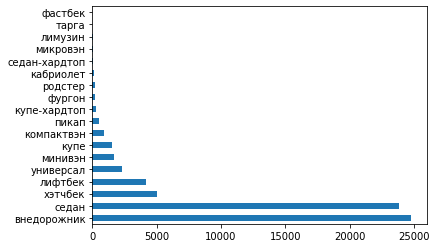

In [30]:
# посмотрим на распределение
data.bodyType.value_counts().plot.barh()

In [31]:
# добавим его в категориальные
cat_cols.append('bodyType')

### brand

In [32]:
data.brand.value_counts()

BMW           8137
VOLKSWAGEN    8106
NISSAN        7793
MERCEDES      7781
TOYOTA        7445
              ... 
ZOTYE            1
DW_HOWER         1
DAIHATSU         1
MG               1
TATRA            1
Name: brand, Length: 70, dtype: int64

In [33]:
data.brand.value_counts().index

Index(['BMW', 'VOLKSWAGEN', 'NISSAN', 'MERCEDES', 'TOYOTA', 'AUDI', 'SKODA',
       'MITSUBISHI', 'VOLVO', 'HONDA', 'LEXUS', 'INFINITI', 'KIA', 'HYUNDAI',
       'FORD', 'RENAULT', 'VAZ', 'LAND_ROVER', 'CHEVROLET', 'MAZDA', 'OPEL',
       'PORSCHE', 'PEUGEOT', 'SUZUKI', 'CITROEN', 'JEEP', 'SUBARU', 'MINI',
       'CADILLAC', 'JAGUAR', 'SSANG_YONG', 'DODGE', 'UAZ', 'BENTLEY',
       'GREAT_WALL', 'GAZ', 'CHRYSLER', 'TESLA', 'GENESIS', 'GEELY', 'DAEWOO',
       'HAVAL', 'ROLLS_ROYCE', 'CHERY', 'LIFAN', 'ALFA_ROMEO', 'FIAT',
       'VORTEX', 'HUMMER', 'LAMBORGHINI', 'ZAZ', 'SEAT', 'FERRARI', 'SMART',
       'MASERATI', 'MOSCVICH', 'RAM', 'SAAB', 'ACURA', 'IRAN_KHODRO', 'DATSUN',
       'LUXGEN', 'SATURN', 'GAC', 'MCLAREN', 'ZOTYE', 'DW_HOWER', 'DAIHATSU',
       'MG', 'TATRA'],
      dtype='object')

In [34]:
cat_cols.append('brand')

### color

In [35]:
data.color.value_counts()

чёрный         20414
белый          12474
серый           8122
серебристый     6977
синий           6171
коричневый      3012
красный         2928
зелёный         1605
бежевый         1205
голубой          830
золотистый       448
пурпурный        443
фиолетовый       362
жёлтый           341
оранжевый        259
розовый           18
Name: color, dtype: int64

<AxesSubplot:>

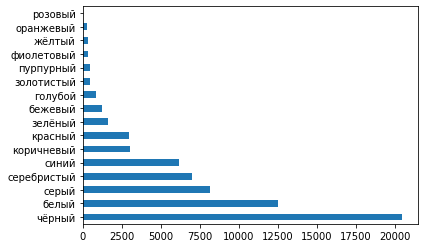

In [36]:
data.color.value_counts().plot.barh()

In [37]:
cat_cols.append('color')

### Description

In [38]:
# description - описание, комментарий продавца
# сгенерируем числовой признак - количество символов в описании
data['description_len'] = data.description.apply(lambda x: len(str(x)))
# сам description удалим
data = data.drop('description',axis=1)

In [39]:
#Определим его как числовой признак
num_cols.append('description_len')

### fuelType

In [40]:
data.fuelType.value_counts()

бензин     53453
дизель     11599
гибрид       407
электро      137
газ           13
Name: fuelType, dtype: int64

<AxesSubplot:>

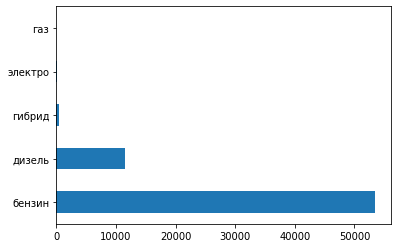

In [41]:
data.fuelType.value_counts().plot.barh()

In [42]:
cat_cols.append('fuelType')

### image

In [43]:
# image - фото автомобиля
# проверим фото на уникальность
count_photos = data.image.value_counts()
count_photos.head(5)

https://avatars.mds.yandex.net/get-verba/216201/2a000001609d0005e0912c12a896bbda4ab1/wizardv3mr     20
https://avatars.mds.yandex.net/get-verba/216201/2a000001609bda17487cc63d8b957ab4aab2/wizardv3mr     13
https://avatars.mds.yandex.net/get-verba/216201/2a0000016098487a9e1ff58d5ae35f3de345/wizardv3mr     13
https://avatars.mds.yandex.net/get-verba/1030388/2a000001609cf6746b94cf8334836265daaf/wizardv3mr    13
https://avatars.mds.yandex.net/get-verba/216201/2a0000016099a4e6be992d7b50134fd908fd/wizardv3mr     12
Name: image, dtype: int64

In [44]:
# получим уникальные фотографии
count_photos.sort_values().head(5)

https://avatars.mds.yandex.net/get-autoru-vos/1597789/8901db0d167eb46f8d027cb182061594/320x240                                                                                                                                   1
https://avatars.mds.yandex.net/get-autoru-vos/2079837/0181c0d053929c3fb87ea4c846769d71/320x240                                                                                                                                   1
https://autoru.naydex.net/LxPU17803/f5b8d77S/uJVf1SOuWPdNdzoobxb1t6-Yu23wDJaRR2ZcysNrimww4vacNxQ2hfKlqvsYKFKXZej1odC38211Hwi5G237xnm0e5DCeuiDOHYfDN4XEAerqQ_odBnj5cIDmd6EaAgvZhEVPlV3ZUPD1AqPGdzm4aN5c5fmg3EIUc4vaCttvnOw#DSD    1
https://avatars.mds.yandex.net/get-autoru-vos/2028022/53feb0cdbed602aa31ca2ac40cda1d26/320x240                                                                                                                                   1
https://avatars.mds.yandex.net/get-autoru-vos/3710589/9351769ecdea4f79360d5a7fc6264ce5/320x2

In [45]:
# можно сделать из этого бинарный признак по типу уникальности фото
data['real_photo'] = data.image.apply(lambda x: x.find('get-verba') == -1)

real = data[data['real_photo'] == False].image.value_counts()
display(real.sort_values().head(5))

# сам признак image удалим
data = data.drop('image',axis=1)

https://avatars.mds.yandex.net/get-verba/216201/2a000001609cec7122d937866cdec93f4b6a/wizardv3mr    1
https://avatars.mds.yandex.net/get-verba/787013/2a000001609d4b3bb7dfac0d25bd885e2318/wizardv3mr    1
https://avatars.mds.yandex.net/get-verba/787013/2a0000016096a742e73286cc1b187296fa0b/wizardv3mr    1
https://avatars.mds.yandex.net/get-verba/787013/2a000001609cea27819d3c6ec59e55d0e3fb/wizardv3mr    1
https://avatars.mds.yandex.net/get-verba/787013/2a000001609a71c88a3cd6d719c0e68200f2/wizardv3mr    1
Name: image, dtype: int64

In [46]:
data['real_photo'].value_counts()

True     65046
False      563
Name: real_photo, dtype: int64

<AxesSubplot:xlabel='real_photo', ylabel='count'>

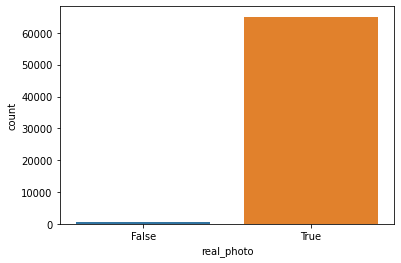

In [47]:
sns.countplot(x = 'real_photo', data = data)

Реальных фото оказалось большинство

In [48]:
bin_cols.append('real_photo')

### engineDisplacement

In [49]:
data.engineDisplacement.unique()

array(['1.2 LTR', '1.6 LTR', '1.8 LTR', '2.0 LTR', '1.4 LTR', '1.3 LTR',
       '1.0 LTR', '3.6 LTR', '1.5 LTR', '1.9 LTR', '2.8 LTR', '1.1 LTR',
       '2.5 LTR', '4.2 LTR', '3.0 LTR', '4.0 LTR', '5.9 LTR', '2.7 LTR',
       '3.1 LTR', '2.4 LTR', '5.2 LTR', '3.2 LTR', '4.1 LTR', '6.3 LTR',
       '2.3 LTR', '6.0 LTR', '2.2 LTR', '3.7 LTR', '2.9 LTR', '5.0 LTR',
       '3.3 LTR', '2.1 LTR', '2.6 LTR', ' LTR', '3.5 LTR', '1.7 LTR',
       '0.7 LTR', '4.4 LTR', '4.8 LTR', '5.4 LTR', '6.6 LTR', '4.9 LTR',
       '3.8 LTR', '3.4 LTR', '3.9 LTR', '4.6 LTR', '5.6 LTR', '4.5 LTR',
       '5.5 LTR', '6.2 LTR', '4.7 LTR', '4.3 LTR', '5.8 LTR', '5.3 LTR',
       '5.7 LTR', '6.8 LTR', '0.8 LTR', '6.4 LTR', '6.5 LTR', '0.9 LTR',
       '0.6 LTR'], dtype=object)

In [50]:
data.engineDisplacement.value_counts()

2.0 LTR    14515
1.6 LTR     9973
3.0 LTR     7514
1.8 LTR     5805
2.5 LTR     4606
           ...  
6.4 LTR        2
0.9 LTR        1
6.5 LTR        1
3.9 LTR        1
0.6 LTR        1
Name: engineDisplacement, Length: 61, dtype: int64

In [51]:
#оставим только численное значение 
data.engineDisplacement = data.engineDisplacement.apply(lambda x: x[:3])
data.engineDisplacement = data.engineDisplacement.replace(' LT', '2.0')
data.engineDisplacement = data.engineDisplacement.apply(lambda x: float(x))

In [52]:
#разобьем по категориям
data["engineDisplacement"] = data["engineDisplacement"].astype('float').apply(lambda x: 4 if x >= 4 else 
   3 if x >= 3 else(2 if x >= 2 else (1 if x >= 1 else 0)))
data.engineDisplacement.value_counts()

2    25241
1    22562
3    12254
4     5463
0       89
Name: engineDisplacement, dtype: int64

<AxesSubplot:xlabel='engineDisplacement', ylabel='count'>

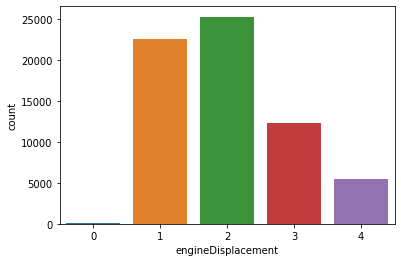

In [53]:
sns.countplot(x = 'engineDisplacement', data = data)

In [54]:
cat_cols.append('engineDisplacement')

### enginePower

In [55]:
data.enginePower.unique()

array(['105 N12', '110 N12', '152 N12', '200 N12', '102 N12', '150 N12',
       '90 N12', '180 N12', '220 N12', '122 N12', '70 N12', '140 N12',
       '125 N12', '54 N12', '86 N12', '75 N12', '64 N12', '95 N12',
       '260 N12', '170 N12', '80 N12', '68 N12', '160 N12', '115 N12',
       '280 N12', '53 N12', '60 N12', '143 N12', '42 N12', '101 N12',
       '58 N12', '193 N12', '79 N12', '30 N12', '100 N12', '50 N12',
       '163 N12', '225 N12', '420 N12', '211 N12', '245 N12', '560 N12',
       '500 N12', '249 N12', '450 N12', '605 N12', '250 N12', '354 N12',
       '120 N12', '290 N12', '230 N12', '350 N12', '204 N12', '255 N12',
       '340 N12', '177 N12', '272 N12', '372 N12', '210 N12', '130 N12',
       '300 N12', '190 N12', '239 N12', '435 N12', '333 N12', '271 N12',
       '326 N12', '238 N12', '310 N12', '233 N12', '252 N12', '133 N12',
       '460 N12', '520 N12', '400 N12', '525 N12', '367 N12', '265 N12',
       '550 N12', '580 N12', '88 N12', '165 N12', '430 N12', '335 N

In [56]:
#преобразуем данные взяв только числовой признак
data['enginePower'] = data['enginePower'].apply(lambda x: x[:3])
data['enginePower'] = data['enginePower'].replace('7 N','7')
data['enginePower'] = data['enginePower'].apply(lambda x: int(x))

<bound method Axes.barh of <AxesSubplot:>>

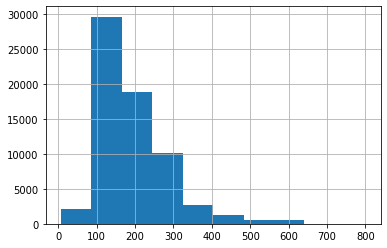

In [57]:
data.enginePower.hist().barh

In [58]:
num_cols.append('enginePower')

### mileage

In [59]:
data['mileage'].value_counts()

200000        448
300000        392
150000        389
250000        364
180000        353
             ... 
88590           1
123334          1
23048           1
169 992 км      1
120192          1
Name: mileage, Length: 25629, dtype: int64

In [60]:
# Исправим данные
data['mileage'] = data['mileage'].apply(lambda x: str(x).replace('\xa0км', ''))

In [61]:
data['mileage'] = data.mileage.apply(
    lambda x: int("".join(filter(str.isdigit, x))))

count      65609.000000
mean      152734.059931
std        98234.485146
min            1.000000
25%        82450.000000
50%       140000.000000
75%       202667.000000
max      1000000.000000
Name: mileage, dtype: float64

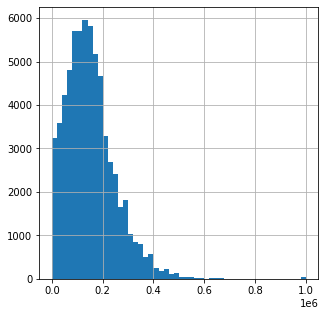

In [62]:
data['mileage'].hist(figsize=(5,5), bins=50)
data.mileage.describe()

In [63]:
#Создадим категориальный признак 'mileage_cat'  
data["mileage_cat"] = data["mileage"].apply(lambda x: 4 if x>=40000 
        else(3 if x>=30000 else(2 if x>=20000 else (1 if x>=10000 else 0))))

In [64]:
data.mileage_cat.value_counts()

4    58896
3     1845
2     1699
1     1595
0     1574
Name: mileage_cat, dtype: int64

In [65]:
num_cols.append('mileage')
cat_cols.append('mileage_cat')

### productionDate и modelDate

In [66]:
data.productionDate.value_counts()

2012    5382
2013    4933
2011    4772
2014    4467
2008    4410
        ... 
1957       1
1938       1
1939       1
1948       1
1949       1
Name: productionDate, Length: 74, dtype: int64

<AxesSubplot:>

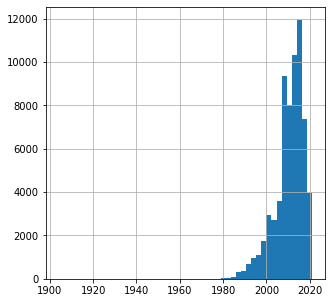

In [67]:
data['productionDate'].hist(figsize=(5,5), bins=50)

In [68]:
data.modelDate.value_counts()

2013    4646
2012    4616
2011    4340
2014    4191
2010    4056
        ... 
1965       1
1904       1
1946       1
1952       1
1950       1
Name: modelDate, Length: 73, dtype: int64

<AxesSubplot:>

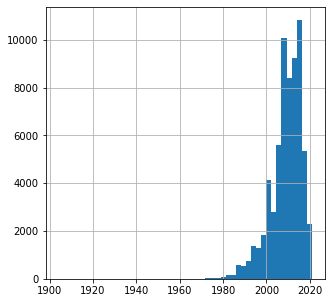

In [69]:
data['modelDate'].hist(figsize=(5,5), bins=50)

In [70]:
# создадим новые признаки на основе существующих: количество лет
# с производства и возраст модели
data['prod_age'] = 2021 - data.productionDate
data['model_age'] = 2021 - data.modelDate

In [71]:
num_cols.append('productionDate')
num_cols.append('modelDate')
num_cols.append('prod_age')
num_cols.append('model_age')

### model_name

In [72]:
data.model_name.unique()

array(['OCTAVIA', 'SUPERB', 'OCTAVIA_RS', ..., 'VAMOS', 'CAPA', 'MDX'],
      dtype=object)

In [73]:
data.model_name.value_counts().index

Index(['OCTAVIA', '5ER', 'CAMRY', 'POLO', 'E_KLASSE', 'LANCER', '3ER',
       'PASSAT', 'A6', 'X_TRAIL',
       ...
       'Mitsubishi Space Star I Рестайлинг', 'Nissan Leaf I (ZE0/AZE0)',
       '100NX', 'Peugeot Partner II Рестайлинг 2',
       'Fiat 500  II Рестайлинг 500e',
       'Mercedes-Benz GLE Coupe  II (C167) 450', 'Hyundai Santa Fe I',
       'Audi S5 I (8T)', 'Honda Civic IX Рестайлинг',
       'Mercedes-Benz CL-Класс  III (C216) 500'],
      dtype='object', length=2173)

In [74]:
cat_cols.append('model_name')

### numberOfDoors

In [75]:
data.numberOfDoors.value_counts()

5    36866
4    25512
2     2129
3     1101
0        1
Name: numberOfDoors, dtype: int64

<AxesSubplot:xlabel='numberOfDoors', ylabel='count'>

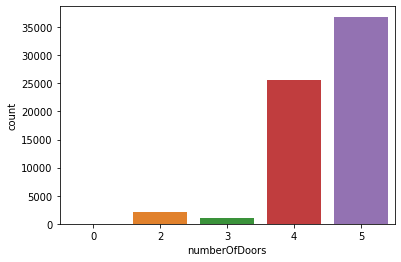

In [76]:
sns.countplot(x = 'numberOfDoors', data = data)

In [77]:
cat_cols.append('numberOfDoors')

### sell_id

идентификатор не информативный признак поэтому не добавляем

### vehicleTransmission

In [78]:
data.vehicleTransmission.value_counts()

автоматическая      37639
механическая        12662
роботизированная     7798
вариатор             7510
Name: vehicleTransmission, dtype: int64

<AxesSubplot:xlabel='vehicleTransmission', ylabel='count'>

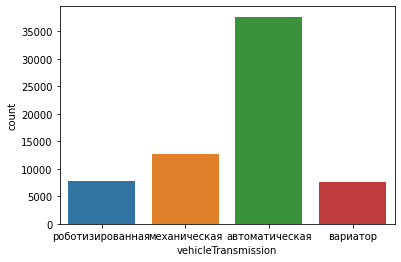

In [79]:
sns.countplot(x = 'vehicleTransmission', data = data)

In [80]:
cat_cols.append('vehicleTransmission')

### Владельцы

In [81]:
data['Владельцы'].value_counts()

3 или более    27688
1 владелец     11879
2 владельца    10713
1 владелец      8517
2 владельца     6812
Name: Владельцы, dtype: int64

In [82]:
# преобразуем данные, оставим только количество владельцев
data['Владельцы'] = data['Владельцы'].apply(lambda x: int(x[0])).astype('int32')

In [83]:
data.Владельцы.value_counts()

3    27688
1    20396
2    17525
Name: Владельцы, dtype: int64

<AxesSubplot:xlabel='Владельцы', ylabel='count'>

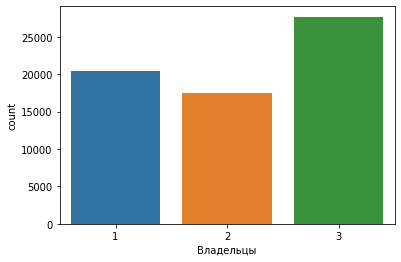

In [84]:
sns.countplot(x = 'Владельцы', data = data)

In [85]:
cat_cols.append('Владельцы')

### ПТС

In [86]:
data.ПТС.value_counts()

Оригинал    57486
Дубликат     8122
Name: ПТС, dtype: int64

In [87]:
data.ПТС.isna().sum()

1

In [88]:
# заполним пропуск наиболее частым значением
data.ПТС = data.ПТС.fillna('Оригинал')

In [89]:
# Преобразуем значения в колонке ПТС
data['ПТС'] = data['ПТС'].apply(lambda x: 1 if x == 'Оригинал' else 0).astype('int8')

<AxesSubplot:xlabel='ПТС', ylabel='count'>

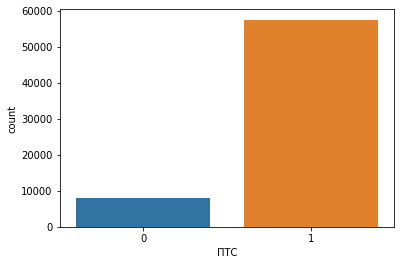

In [90]:
sns.countplot(x = 'ПТС', data = data)

In [91]:
#определяем в бинарные признаки
bin_cols.append('ПТС')

### Привод

In [92]:
data.Привод.value_counts()

передний    29352
полный      29242
задний       7015
Name: Привод, dtype: int64

<AxesSubplot:xlabel='Привод', ylabel='count'>

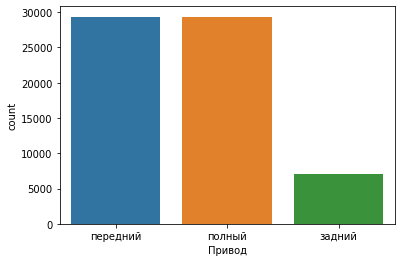

In [93]:
#посмотрим на распределение
sns.countplot(x = 'Привод', data = data)

In [94]:
cat_cols.append('Привод')

### Руль

In [95]:
data.Руль.value_counts()

Левый     63355
Правый     2254
Name: Руль, dtype: int64

<AxesSubplot:xlabel='Руль', ylabel='count'>

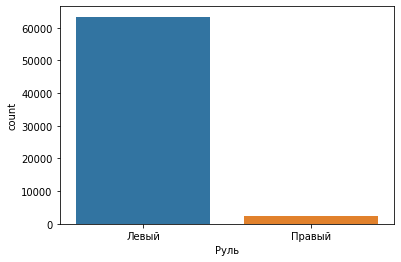

In [96]:
sns.countplot(x = 'Руль', data = data)

In [97]:
# Преобразуем значения в колонке Руль
data['Руль'] = data['Руль'].apply(lambda x: 1 if x == 'Левый' else 0).astype('int8')

In [98]:
bin_cols.append('Руль')

### Состояние

In [99]:
data.Состояние.unique()

array(['Не требует ремонта', 'Битый / не на ходу'], dtype=object)

In [100]:
# Преобразуем значения в колонке Состояние
data['Состояние'] = data['Состояние'].apply(lambda x: 1 if x == 'Не требует ремонта' else 0).astype('int8')

In [101]:
data.Состояние.value_counts()

1    65607
0        2
Name: Состояние, dtype: int64

In [102]:
bin_cols.append('Состояние')

### Цеевая переменная price

In [103]:
data['price'].value_counts()

0              34686
650000           259
750000           232
1100000          199
450000           194
               ...  
8490000            1
485000             1
6 349 000 ₽        1
3 962 000 ₽        1
1677000            1
Name: price, Length: 5487, dtype: int64

In [104]:
# приведем целевую переменную к числовому типу
data['price'] = data['price'].apply(lambda x: str(x))
data.price = data.price.apply(
    lambda x: ("".join(filter(str.isdigit, x)))).astype('int')

<AxesSubplot:title={'center':'Распределение price'}, xlabel='price'>

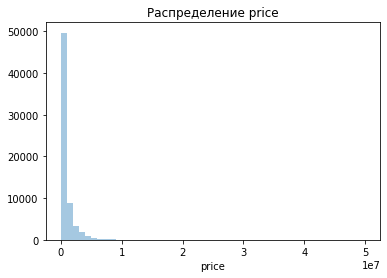

In [105]:
plt.figure()
plt.title(f"Распределение {'price'}")
sns.distplot(data.price, kde=False)

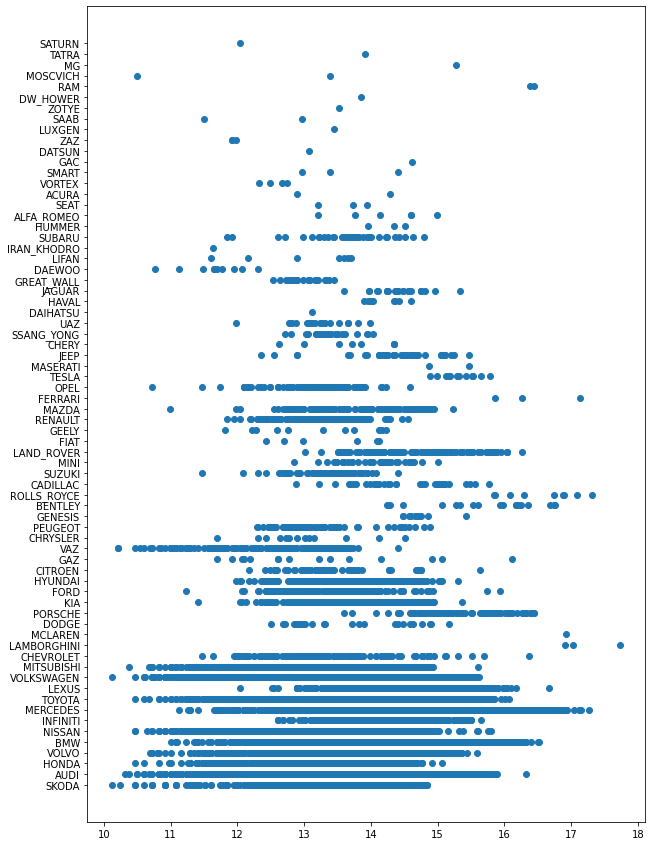

In [106]:
# Посмотрим на распределение зависимости цены от марки авто
plt.figure(figsize=(10, 15))
plt.scatter(np.log(data.price), data.brand)

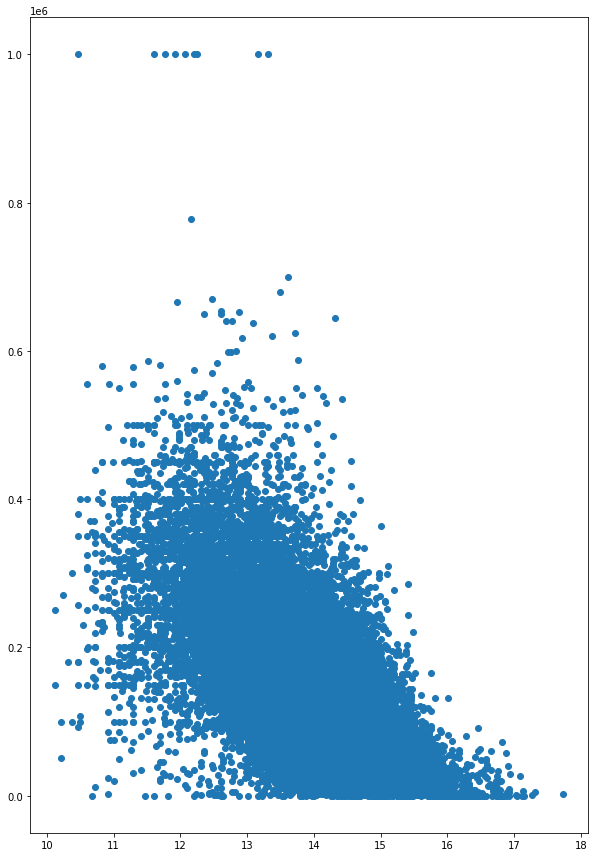

In [107]:
# Посмотрим на распределение зависимости цены от километража
plt.figure(figsize=(10, 15))
plt.scatter(np.log(data.price), data.mileage)

In [108]:
data.info(
)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65609 entries, 0 to 68216
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              65609 non-null  object 
 1   brand                 65609 non-null  object 
 2   car_url               65609 non-null  object 
 3   color                 65609 non-null  object 
 4   engineDisplacement    65609 non-null  int64  
 5   enginePower           65609 non-null  int64  
 6   fuelType              65609 non-null  object 
 7   mileage               65609 non-null  int64  
 8   modelDate             65609 non-null  int64  
 9   model_name            65609 non-null  object 
 10  name                  65609 non-null  object 
 11  numberOfDoors         65609 non-null  int64  
 12  parsing_unixtime      34686 non-null  float64
 13  priceCurrency         65609 non-null  object 
 14  productionDate        65609 non-null  int64  
 15  sell_id            

Удалим признаки, которые на наш взгляд не несут никакой информативности,либо дублируют информацию:

In [109]:
data = data.drop(columns = ['car_url','name','sell_id',
    'parsing_unixtime','vehicleConfiguration','priceCurrency','Таможня'], axis=1)

In [110]:
data.head(2)

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,numberOfDoors,...,Привод,Руль,Состояние,price,sample,description_len,real_photo,mileage_cat,prod_age,model_age
0,лифтбек,SKODA,синий,1,105,бензин,74000,2013,OCTAVIA,5,...,передний,1,1,0,0,1001,True,4,7,8
1,лифтбек,SKODA,чёрный,1,110,бензин,60563,2017,OCTAVIA,5,...,передний,1,1,0,0,2609,True,4,4,4


# Label Encoding

In [111]:
for colum in ['bodyType','color','model_name','brand','fuelType',
            'vehicleTransmission','Привод','real_photo']:
    data[colum] = data[colum].astype('category').cat.codes

In [112]:
data.sample(5)

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,numberOfDoors,...,Привод,Руль,Состояние,price,sample,description_len,real_photo,mileage_cat,prod_age,model_age
68043,0,24,11,2,150,0,151000,2008,424,5,...,2,1,1,900000,1,334,1,4,13,13
11833,0,45,1,1,117,0,70000,2010,817,5,...,1,1,1,0,0,152,1,4,8,11
35944,17,45,15,2,109,4,71000,2010,1431,5,...,1,0,1,465000,1,314,1,4,8,11
33478,0,62,1,4,249,3,109906,2015,968,5,...,2,1,1,0,0,1096,1,4,5,6
67934,11,24,1,1,140,0,212932,2011,393,4,...,1,1,1,675000,1,628,1,4,10,10


In [113]:
print('Категориальныe: {} \nБинарные: {}\nЧисловые: {}'.format(cat_cols, bin_cols,num_cols))

Категориальныe: ['bodyType', 'brand', 'color', 'fuelType', 'engineDisplacement', 'mileage_cat', 'model_name', 'numberOfDoors', 'vehicleTransmission', 'Владельцы', 'Привод'] 
Бинарные: ['real_photo', 'ПТС', 'Руль', 'Состояние']
Числовые: ['description_len', 'enginePower', 'mileage', 'productionDate', 'modelDate', 'prod_age', 'model_age']


# Бинарные признаки

In [114]:
data.price.value_counts(bins=4)

(-50000.001, 12500000.0]    65510
(12500000.0, 25000000.0]       91
(25000000.0, 37500000.0]        7
(37500000.0, 50000000.0]        1
Name: price, dtype: int64

<AxesSubplot:>

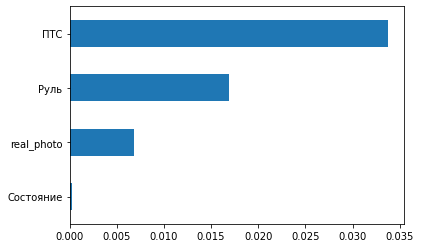

In [115]:
#Проверим значимость бинарных переменных:
df = data[data['sample'] == 0]
imp_cat = Series(mutual_info_classif(data[bin_cols], data['price'],
                                     discrete_features =True), index = bin_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

из графика видно,что сильно больше всего влияют признаки ПТС и Руль на цену

<AxesSubplot:>

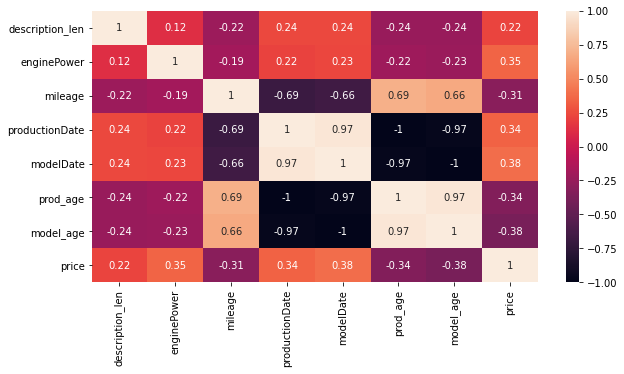

In [116]:
# построим матрицу корреляций для числовых признаков
plt.figure(figsize=(10,5))
sns.heatmap(data[num_cols+['price']].corr(), annot=True)

# Категориальные признаки

<AxesSubplot:>

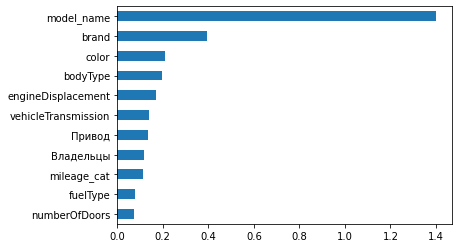

In [117]:
# Проверим значимость категориальных переменных:
temp_df = data[data['sample']==1]
imp_cat = Series(mutual_info_classif(data[cat_cols], data['price'],
                                     discrete_features=True), index=cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

Марка машины логично существенно влияет на цену

# Числовые признаки

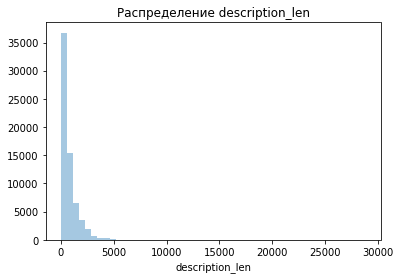

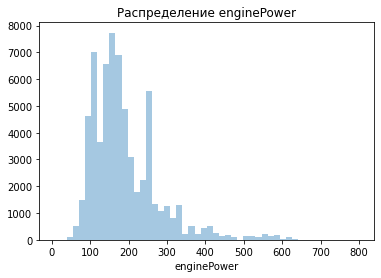

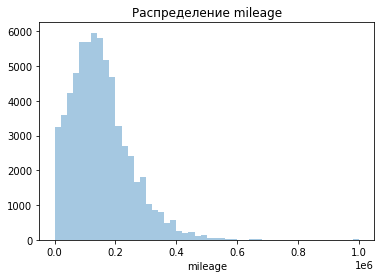

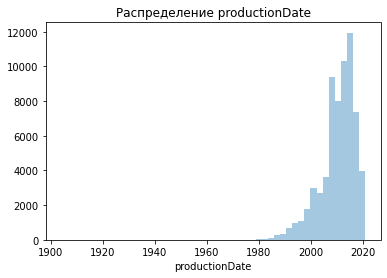

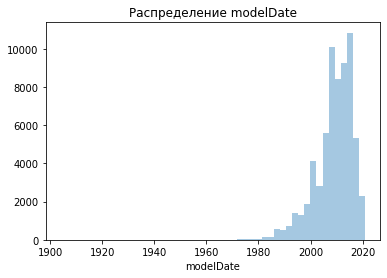

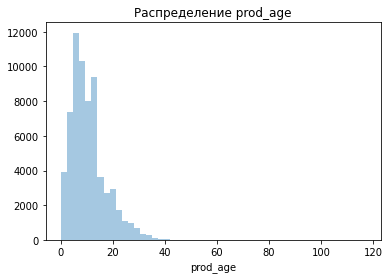

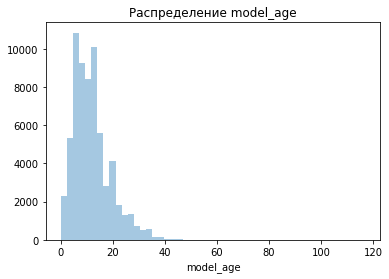

In [118]:
# анализ распределения числовых переменных с помощью визуализации
for col in num_cols:
    plt.figure()
    plt.title(f"Распределение {col}")
    sns.distplot(data[col], kde=False)

<AxesSubplot:>

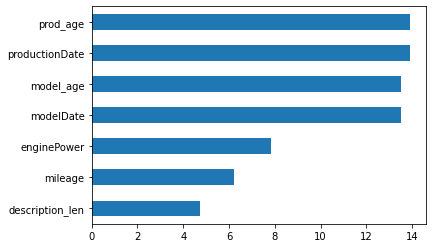

In [119]:
imp_num = Series(f_classif(data[num_cols][data['sample'] == 1], data[data['sample'] == 1]['price'])[0], 
                 index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [120]:
# Данные распределенны неравномерно поэтому прологарифируем переменные

In [121]:
for col in num_cols:
    data[col]=data[col].apply(lambda x:np.log(x))

In [122]:
data.prod_age = data.prod_age.apply(lambda x: -1 if x == -np.inf else x)
data.model_age = data.model_age.apply(lambda x: -1 if x == -np.inf else x)

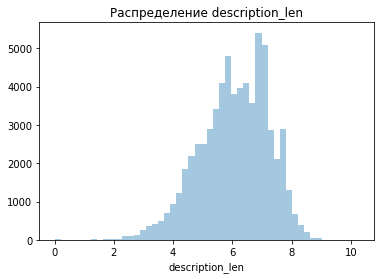

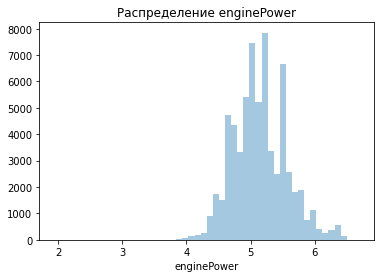

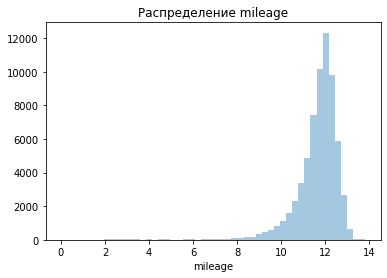

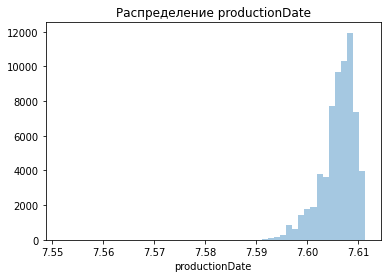

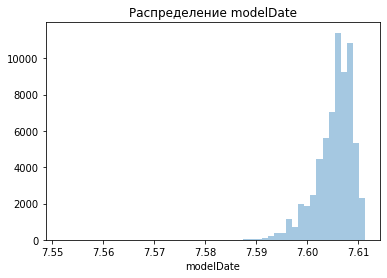

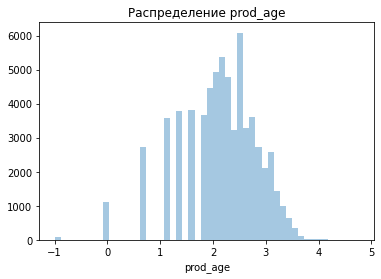

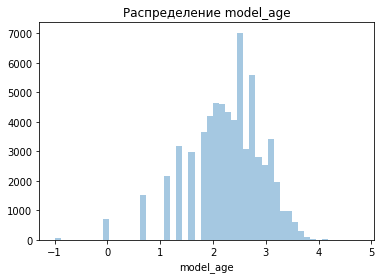

In [123]:
for col in num_cols:
    plt.figure()
    plt.title(f"Распределение {col}")
    sns.distplot(data[col], kde=False)

Все признаки значительно влияют на цену

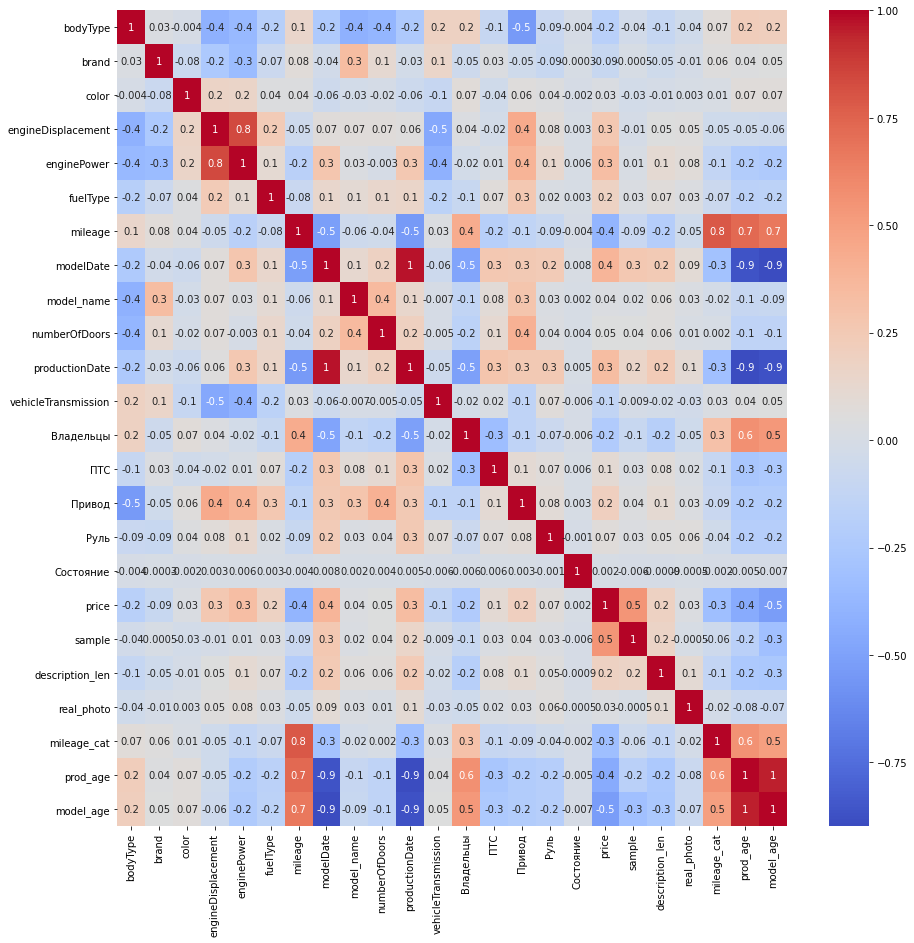

In [124]:
# корреляция

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax = sns.heatmap(data.corr(),fmt='.1g',
                 annot=True, cmap='coolwarm')

Видны явно коррелирующие признаки убрать их не будем т.к. это не дало прироста в метрике

# Train Split

In [125]:
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample','price'], axis=1)
X = train_data.drop(['price'], axis=1)
y = train_data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    shuffle=True, random_state=RANDOM_SEED)

# Model 1: Создадим "наивную" модель

Эта модель будет предсказывать среднюю цену по модели двигателя (engineDisplacement). C ней будем сравнивать другие модели.

In [126]:
tmp_train = X_train.copy()
tmp_train['price'] = y_train

In [127]:
# Находим median по экземплярам engineDisplacement в трейне и размечаем тест
predict = X_test['engineDisplacement'].map(tmp_train.groupby('engineDisplacement')['price'].median())
VERSION = 1
#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict.values))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 95.03%


# Простая модель линейной регрессии

In [128]:
from sklearn.linear_model import LinearRegression
linear_regr = LinearRegression().fit(X_train, np.log(y_train+1))
VERSION = 2
predict_test = np.exp(linear_regr.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 24.55%


# CatBoost

In [129]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, y_train,
         #cat_features=cat_features_ids,
         eval_set=(X_test, y_test),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

model.save_model('catboost_single_model_baseline.model')

In [130]:
# оцениваем точность
VERSION = 3
predict = model.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели по метрике MAPE: 14.96%


Log Target
Попробуем взять таргет в логорифм - это позволит уменьшить влияние выбросов на обучение модели (используем для этого np.log и np.exp).

In [131]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, np.log(y_train),
         #cat_features=cat_features_ids,
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

model.save_model('catboost_single_model_2_baseline.model')
predict_test = np.exp(model.predict(X_test))
#predict_submission = np.exp(model.predict(test_data))
VERSION = 4
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 12.52%


12.52

# xgboost

In [132]:
xb = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5, learning_rate=0.03, \
                      max_depth=12, alpha=1, n_jobs=-1, n_estimators=1000)
xb.fit(X_train, np.log(y_train+1))
print(f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(xb.predict(X_test))))*100:0.2f}%")
VERSION = 5
predict_test = np.exp(xb.predict(X_test))
predict_submission = np.exp(xb.predict(test_data))

Точность модели по метрике MAPE: 12.13%


12.13

# Random Forest

In [133]:
rf = RandomForestRegressor(random_state = RANDOM_SEED, n_jobs = -1, verbose = 1).fit(X_train, 
                                                                        np.log(y_train+1))
print(f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(rf.predict(X_test))))*100:0.2f}%")
VERSION = 6

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s


Точность модели по метрике MAPE: 14.19%


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [134]:
#Зададим сетку гиперпараметров, которые будут перебираться:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

закомментируем дальнейший код т.к. слишком долго обрабатывается

In [135]:
# #Обучим наш лес:
# rf = RandomForestRegressor(random_state=42)
# rf_rand = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, 
#                               cv=3, verbose=2, random_state=42, n_jobs=-1)
# rf_rand.fit(X_train, np.log(y_train+1))
# print(f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(rf.predict(X_test))))*100:0.2f}%")
# VERSION = 7

# GradientBoosting с подбором параметров

In [136]:
def regularise(X_train, y_train):
    max_depth = [5, 10,15]
    n_estimators = [100, 200,1000]
    hyperparameters = dict(max_depth=max_depth, n_estimators=n_estimators)
    model = GradientBoostingRegressor()
    model.fit(X_train, y_train)

    clf = GridSearchCV(model, hyperparameters)

    best_model = clf.fit(X_train, y_train)

    best_max_depth = best_model.best_estimator_.get_params()['max_depth']
    best_n_estimators = best_model.best_estimator_.get_params()['n_estimators']

    return best_max_depth, best_n_estimators

Долгий подсчет закоментируем

In [137]:
# best_max_depth, best_n_estimators = regularise(X_train, y_train)
# best_max_depth, best_n_estimators

In [138]:
# gb = GradientBoostingRegressor(min_samples_split=2, learning_rate=0.03, max_depth=5,
#                                n_estimators=1000)
# gb.fit(X_train, np.log(y_train+1))
# print(f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(gb.predict(X_test))))*100:0.2f}%")
# VERSION = 8

Точность модели по метрике MAPE: 13.81%

### Проведя ряд экспериментов и используя различные алгоритмы можно сделать следующие выводы:

- Почти все методы показывают хороший результат метрики, но лучший результат показал xgboost - 12.13.
- Заметно улучшается результат после логарифмирования целевой переменной.

# Submission

In [139]:
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_2_v{VERSION}.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1100575026,6.697804e+05
1,1100549428,9.962137e+05
2,1100658222,9.239507e+05
3,1100937408,7.974400e+05
4,1101037972,7.523451e+05
5,1100912634,7.435716e+05
6,1101228730,6.611729e+05
7,1100165896,4.483107e+05
8,1100768262,2.138522e+06
9,1101218501,8.035702e+05
